In [66]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as st
from scipy.stats import t
import random as rand

import BA_C

from sklearn.metrics import auc

import copy

In [67]:
def linear(x,a,b):
    return (a + b*x)

In [68]:
def nonlinear(x,a,b):
    return (np.exp(a + b*x))
    #return (a + b*np.power(x,c))

In [69]:
data_folder = '/Users/sns9/CodeX/ProVia/data/cytotoxicity'
os.chdir(data_folder)

x_dict = {}
x_dict['AH'] = 'Healthy cells (%)'
x_dict['AN'] = 'Necrotic cells (%)'
x_dict['AEA'] = 'Early Apoptotic cells (%)'
x_dict['AH'] = 'Healthy cells (%)'

In [70]:
#v0 = pd.read_csv('Annexin0h-LDH.csv')
v24 = pd.read_csv('cytotoxicity_data.csv')

print(list(v24))

['TH', 'Assay18', 'AODAPI18', 'Assay20', 'AODAPI20', 'Assay22', 'AODAPI22', 'Assay24', 'AODAPI24']


In [71]:
tags = ['18','20','22','24']

weight1 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.95])
#weight1 = pd.Series([0.2, 0.3, 0.4, 0.6, 0.75, 0.9])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

In [72]:
all_data = {}

for tag in tags:
    all_data['Assay'+tag] = v24['Assay'+tag].to_numpy()
    all_data['T2-'+tag] = 85.67*np.power(v24['AODAPI'+tag].to_numpy()/100,-1.7)
    
    #all_data['T2-'+tag] = 2.53*v24['TH'].to_numpy() + 84

In [73]:
cytos, t2s = [], []

for tag in tags:
    for a,b in zip(all_data['Assay'+tag],all_data['T2-'+tag]):
        cytos.append(a)
        t2s.append(b)   

In [74]:
dof = len(t2s) - 2
    
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

print(ts)

2.042272456301238


In [75]:
results = optim.curve_fit(nonlinear,cytos,t2s,absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))
norm_pcov = np.ones(shape=pcov.shape)
norm_pcov[0,1] = pcov[0,1]/(p_std[0]*p_std[1])
norm_pcov[1,0] = pcov[0,1]/(p_std[0]*p_std[1])

print(popt)
print(pcov)
print(norm_pcov)

#fitname = r'T2$_{\mathrm{est}}$ = exp(' + str(round(popt[0],3)) + ' - ' + str(round(popt[1],3)) + '$(100-C)$)'

fitname = r'T2$_{\mathrm{est}}$ = exp(' + str(round(popt[0],3)) + '+' + str(round(popt[1],3)) +'LDH)'

[4.33504445 0.01561423]
[[ 5.47506928e-04 -8.84918894e-06]
 [-8.84918894e-06  1.81066088e-07]]
[[ 1.         -0.88877146]
 [-0.88877146  1.        ]]


In [76]:
mean_cyto = np.linspace(np.min(cytos),np.max(cytos),100)
mean_t2 = nonlinear(mean_cyto,popt[0],popt[1])

In [77]:
residual = nonlinear(np.array(cytos),popt[0],popt[1]) - np.array(t2s)
norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t2s)-2))
print(norm_RSS)

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

8.447357779143777


s_is, i_is = [], []

t2_up = np.zeros(shape=mean_cyto.shape)
t2_low = np.zeros(shape=mean_cyto.shape)

sigma = np.zeros(shape=mean_cyto.shape)

for i in range(0,mean_cyto.shape[0]):
    samples = []
    
    G = gradient(mean_cyto[i],popt[0],popt[1])
    
    y = np.matmul(pcov,G)
    
    c = np.matmul(np.transpose(G),np.matmul(pcov,G))
    
    ci = math.sqrt(c)*ts
    
    sigma[i] = ci
    
    t2_low[i], t2_up[i] = mean_t2[i] - ci, mean_t2[i] + ci

In [78]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_cyto.shape)
t2_low = np.zeros(shape=mean_cyto.shape)

rt2_up = np.zeros(shape=mean_cyto.shape)
rt2_low = np.zeros(shape=mean_cyto.shape)

effective_sigma = np.zeros(shape=mean_cyto.shape)

for i in range(0,mean_cyto.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(mean_cyto[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    t2_low[i], t2_up[i] = mean_t2[i] - ci95, mean_t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = mean_t2[i] - sigma*ts, mean_t2[i] + sigma*ts

3.386454183 76.02531052


Text(25, 80, 'T2$_{\\mathrm{est}}$ = exp(4.335+0.016LDH)')

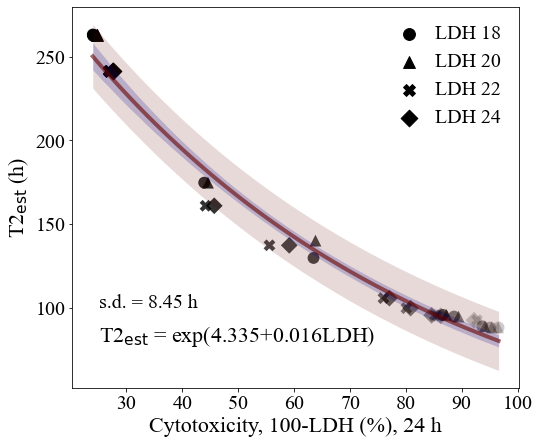

In [79]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

markers = {'18':'o','20':'^','22':'X','24':'D'}

for tag in tags:
    plt.scatter(100-all_data['Assay'+tag],all_data['T2-'+tag],marker=markers[tag],linewidth=0,s=140,c=colors1)
    
    plt.scatter(100-all_data['Assay'+tag][-1],all_data['T2-'+tag][-1],marker=markers[tag],s=140,c='black',label='LDH '+tag)
    
plt.xticks(size=20)
plt.yticks(size=20) 

#plt.xscale('log')
#plt.yscale('log')

print(np.min(mean_cyto),np.max(mean_cyto))

plt.plot(100-mean_cyto,mean_t2,linewidth=4,color='#660000',alpha=0.6)#,label=fitname)

plt.fill_between(100-mean_cyto,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(100-mean_cyto,rt2_up,rt2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.legend(frameon=False,prop={'size': 20},markerscale=1.0,handlelength=1.0,loc='best')

plt.xlabel(r'Cytotoxicity, 100-LDH (%), 24 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)

plt.text(25,100,RSS_text,fontsize=20)

#plt.plot(np.linspace(52,54,2),53*np.ones(2,),color='#660000',alpha=0.6,lw=3)


plt.text(25,80,fitname,fontsize=22)


#plt.savefig('cytotoxicity-day1-v2-TH.png',dpi=300)

In [80]:
data_folder = '/Users/sns9/CodeX/ProVia/data/cutoff'
os.chdir(data_folder)

# False positivity rate
pvalue = 0.05

T2_cutoff = np.zeros(shape=mean_cyto.shape)

wf = open('cytotoxicity_t2_mean.csv','w')

for i in range(0,mean_cyto.shape[0]):
    T2_cutoff[i] = st.t.ppf(1-pvalue,df=dof,loc=mean_t2[i],scale=effective_sigma[i])
    
    print(str(mean_cyto[i])+','+str(T2_cutoff[i]),file=wf)
    
wf.close()

data_folder = '/Users/sns9/CodeX/ProVia/data/cytotoxicity'
os.chdir(data_folder)

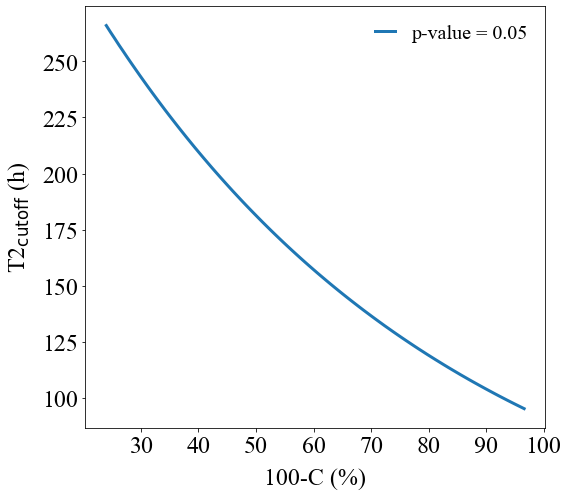

In [16]:
#fig, axs = plt.subplots(figsize=(8,7))
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(100-mean_cyto,T2_cutoff,lw=3.0,label=r'p-value = 0.05')
        
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'100-C (%)',size=24,labelpad=10)
plt.ylabel(r'T2$_{\mathrm{cutoff}}$ (h)',size=24,rotation=90,labelpad=10)
#plt.xlim(50,100)
#plt.ylim(0,1.75)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='best')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('AODAPI-T2-cutoff_prob-v2.png',dpi=300)

In [20]:
mean_cyto2 = np.linspace(0.9*np.min(mean_cyto),1.15*np.max(mean_cyto),1000)

n_samples = 10000

s_is, i_is = [], []

t2 = np.zeros(shape=mean_cyto2.shape)

t2_up = np.zeros(shape=mean_cyto2.shape)
t2_low = np.zeros(shape=mean_cyto2.shape)

rt2_up = np.zeros(shape=mean_cyto2.shape)
rt2_low = np.zeros(shape=mean_cyto2.shape)

effective_sigma = np.zeros(shape=mean_cyto2.shape)

for i in range(0,mean_cyto2.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
    
    t2[i] = nonlinear(mean_cyto2[i],popt[0],popt[1])
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(mean_cyto2[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

In [21]:
#test_t2s = [100,150,200,250,300]
test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
#test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]
#test_t2s.reverse()

#test_t2s = list(np.linspace(96,264,2))
print(test_t2s[1] - test_t2s[0])
test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_cyto2.shape)
    pdfs[k] = np.zeros(shape=mean_cyto2.shape)
    cdfs[k] = np.zeros(shape=mean_cyto2.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_cyto2.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_cyto2.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    
    x = copy.deepcopy(pdfs[k])#[::-1])
    cdfs[k] = np.round(np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])]),3)
    
    responses[j,:] = pdfs[k]
    
    j += 1
    
c, e, p = BA_C.get_CC(responses)
print(c)

12
2.438643965405614


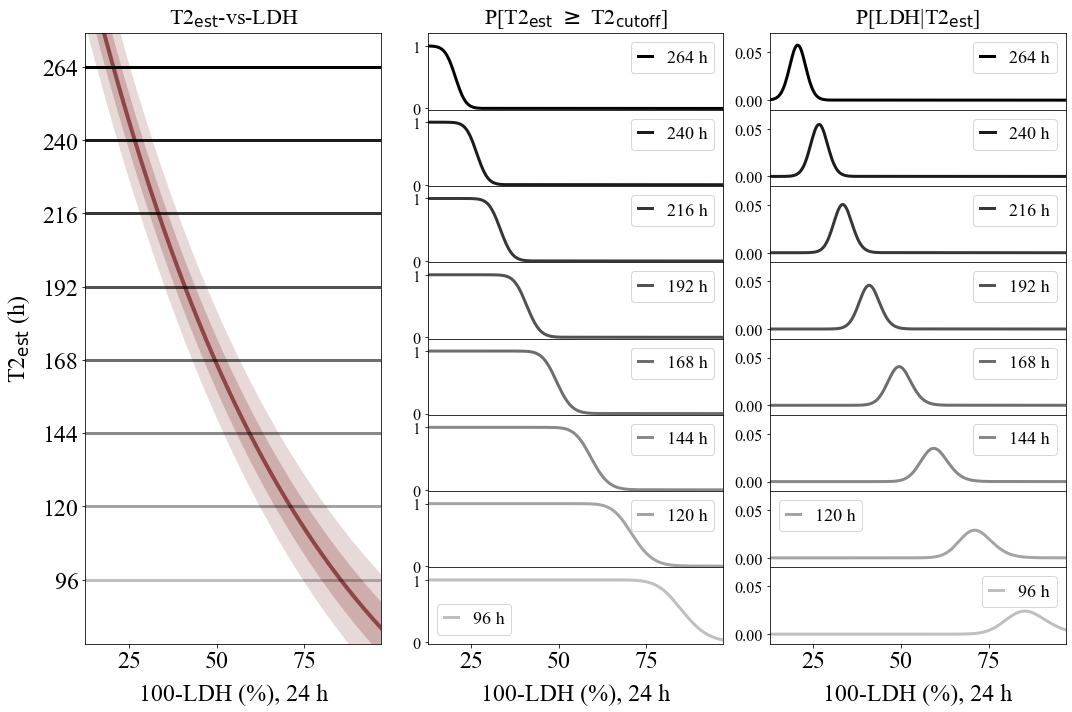

In [36]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(100-mean_cyto2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

ax.fill_between(100-mean_cyto2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(100-mean_cyto2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2$_{\mathrm{est}}$-vs-LDH',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
#ax.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'100-LDH (%), 24 h',size=24,labelpad=10)
ax.set_ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,t*np.ones(shape=mean_cyto2.shape[0]),color='black',lw=3,alpha=_alpha)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2$_{\mathrm{est}}$ $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'100-LDH (%), 24 h',size=24,labelpad=10)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    #ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.07)#1.2*np.max(probs_2[test_t2s[k]]))
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[LDH|T2$_{\mathrm{est}}$]',size=22,pad=10)
          
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'100-LDH (%), 24 h',size=24,labelpad=10)
    
#ax.tight_layout()

plt.savefig('cyto-24h-T2-probabilities-combined.png',dpi=300)

In [ ]:
test_t2s.reverse()

wf = open('cyto24h-T2-cutoff0.05.csv','w')

print('T2_cutoff,p-value,cyto')

l = mean_cyto2.shape[0]-1

for k in test_t2s:
    for i in range(0,mean_cyto2.shape[0]):
        a = round(st.t.sf(k,df=dof,loc=t2[l-i],scale=effective_sigma[l-i]),3)
        
        if a<=0.05:
            v = round(100-mean_cyto2[l-i],1)
            break
        else:
            v = 'N/A'
    
    print(k,a,v)
    
    outstring = str(k) + ',' + str(a) + ',' + str(v)
    
    print(outstring,file=wf)
    
wf.close()

fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(len(test_t2s), hspace=0)

axs = gs.subplots(sharex=True)

for k in range(0,len(test_t2s)):
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    axs[k].plot(100-mean_cyto2,probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].tick_params(axis='y',labelsize=12)
    axs[k].set_xlim(48,102)
    
    
    #axs[k].set_ylim(-0.005,1.2*np.max(probs[test_t2s[k]]))
    
    #plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
    
    axs[k].legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    if k==4:
        axs[k].set_ylabel(r'P[100-$C$ (%)]',size=24,rotation=90,labelpad=10)
    
plt.xticks(size=24) 
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'100-$C$ (%)',size=24,labelpad=10)
#plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
plt.xlim(100-np.max(mean_cyto2),100-np.min(mean_cyto2))

plt.tight_layout()

#plt.savefig('cyto-T2-cuts.png',dpi=300)

test_t2s = [100,150,200,250,300]
probs = {}

for k in test_t2s:
    probs[k] = np.zeros(shape=mean_cyto.shape)
    
for k in test_t2s:
    for i in range(0,mean_cyto.shape[0]):
        #probs[k][i] = st.norm.sf(k,loc=t2[i],scale=sigma[i])
        probs[k][i] = st.t.sf(k,df=dof,loc=mean_t2[i],scale=effective_sigma[i])
            
    #probs[k] *= 1.0/np.sum(probs[k])

fig, axs = plt.subplots(figsize=(8,7))
#fig, axs = plt.subplots(figsize=(10,9))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

for k in test_t2s:
    plt.plot(100-mean_cyto2,probs[k],lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    #plt.plot(probs[k],100-mean_cyto,lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' (h)')
    
    
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'Cytotoxicity, 100-$C$ (%)',size=22)
#plt.ylabel(r'P[100-$C$ (%)]',size=22)
plt.ylabel(r'P[T2$_{\mathrm{expected}} \geq$T2$_{\mathrm{cutoff}}$]',size=24,rotation=90,labelpad=10)
#plt.xlim(50,100)
#plt.ylim(0,0.075)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper right')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('cytotoxicity-T2-cutoff_prob-day1-48h.png',dpi=300)

1
[0, 1]


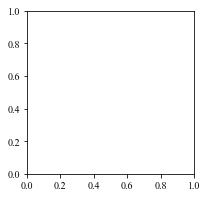

In [35]:
wd = 3

data_skip = 1#int((len(test_t2s)-1)/3)
print(data_skip)

good_indices = [0]

for kk in range(1,len(test_t2s)):
    this_index = good_indices[-1] + data_skip
    
    if this_index>len(test_t2s):
        break
    else:
        good_indices.append(this_index)
    
print(good_indices)

#l = int((len(test_t2s)-1)*wd)

l = int((len(good_indices)-1)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(good_indices)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

#for k in range(0,len(test_t2s)-1):
for ik in range(0,len(good_indices)-1):
    k = good_indices[ik]
    
    #dx = copy.deepcopy(cdfs[test_t2s[k]][::-1])
    #dy = copy.deepcopy(cdfs[test_t2s[k+1]][::-1])
    
    all_aucs.append(auc(cdfs[test_t2s[k]][::-1],cdfs[test_t2s[k+1]][::-1]))
    
    #all_aucs.append(auc(dx_2,dy_2))
    
    label_text = str(round(all_aucs[-1],3))
    
    #axs[ik].plot(cdfs[test_t2s[k]],cdfs[test_t2s[k+1]],lw=2,color='black',label=label_text)
    #axs[ik].fill_between(cdfs[test_t2s[k]],0,cdfs[test_t2s[k+1]],color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    #axs[ik].set_xticks((0,1))
    #axs[ik].set_yticks((0,1))
    #axs[ik].tick_params(axis='both',labelsize=16)
    #axs[ik].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    #axs[ik].set_title(str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h',fontsize=16)
    
    #if k%2==0:
    #    axs[k].xaxis.tick_top()
    
    #axs[k].set_title('AUC = '+str(round(all_aucs[-1],3)),fontsize=16)
    
        
#print(max(all_aucs))
#plt.tight_layout()
#plt.savefig('cytotoxicity-AUC-12h-s.png',dpi=300)  

try:
    wf = open('min_AUC_summary.csv','a')
    wf.close()
except FileNotFoundError:
    wf = open('min_AUC_summary.csv','w')
    wf.close()
    
print(str(abs(round(test_t2s[0]-test_t2s[1],0)))+','+str(round(min(all_aucs),2)),file=open('min_AUC_summary.csv','a'))

In [24]:
#v0 = pd.read_csv('Annexin0h-LDH.csv')
v0 = pd.read_csv('cytotoxicity_data-day0.csv')

print(list(v0))

tags = ['17','19','21','23']

weight1 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.95])
#weight1 = pd.Series([0.2, 0.3, 0.4, 0.6, 0.75, 0.9])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

['TH', 'Assay17', 'AODAPI17', 'Assay19', 'AODAPI19', 'Assay21', 'AODAPI21', 'Assay23', 'AODAPI23']


In [25]:
all_data = {}

for tag in tags:
    all_data['Assay'+tag] = v0['Assay'+tag].to_numpy()
    all_data['T2-'+tag] = 81.61*np.power(v0['AODAPI'+tag].to_numpy()/100,-1.8)


In [26]:
cytos, t2s = [], []

for tag in tags:
    for a,b in zip(all_data['Assay'+tag],all_data['T2-'+tag]):
        cytos.append(a)
        t2s.append(b) 

In [27]:
results = optim.curve_fit(linear,cytos,t2s,absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))
norm_pcov = np.ones(shape=pcov.shape)
norm_pcov[0,1] = pcov[0,1]/(p_std[0]*p_std[1])
norm_pcov[1,0] = pcov[0,1]/(p_std[0]*p_std[1])

print(popt)
print(pcov)
print(norm_pcov)

#fitname = r'T2$_{\mathrm{est}}$ = exp(' + str(round(popt[0],3)) + ' - ' + str(round(popt[1],3)) + '$(100-C)$)'

fitname = r'T2$_{\mathrm{est}}$ = ' + str(round(popt[0],3)) + '+' + str(round(popt[1],3)) +'LDH'

[-32.57705776  19.5479519 ]
[[1709.70494741 -201.90439033]
 [-201.90439033   24.85283245]]
[[ 1.         -0.97948374]
 [-0.97948374  1.        ]]


In [28]:
mean_cyto = np.linspace(np.min(cytos),np.max(cytos),50)
mean_t2 = linear(mean_cyto,popt[0],popt[1])

In [29]:
residual = linear(np.array(cytos),popt[0],popt[1]) - np.array(t2s)

norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t2s)-2))

print(norm_RSS)

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

47.13685535501469


In [30]:
result = st.linregress(np.array(cytos),t2s,alternative='two-sided')
print(result)

r_text = r'R$^2 = ' + str(round(result.rvalue**2,3)) + '$'

LinregressResult(slope=19.54795169576656, intercept=-32.577055997909156, rvalue=0.582107304948705, pvalue=0.00047402575237523627, stderr=4.985261432869679, intercept_stderr=41.348578093842775)


In [31]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_cyto.shape)
t2_low = np.zeros(shape=mean_cyto.shape)

rt2_up = np.zeros(shape=mean_cyto.shape)
rt2_low = np.zeros(shape=mean_cyto.shape)

effective_sigma = np.zeros(shape=mean_cyto.shape)

for i in range(0,mean_cyto.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_cyto[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    t2_low[i], t2_up[i] = mean_t2[i] - ci95, mean_t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = mean_t2[i] - sigma*ts, mean_t2[i] + sigma*ts

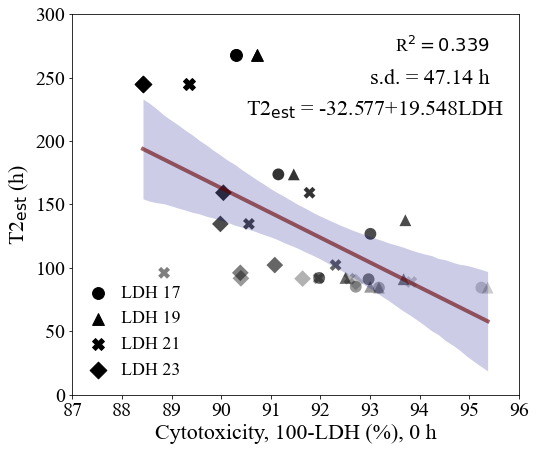

In [35]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

markers = {'17':'o','19':'^','21':'X','23':'D'}

for tag in tags:
    plt.scatter(100-all_data['Assay'+tag],all_data['T2-'+tag],marker=markers[tag],linewidth=0,s=140,c=colors1)
    
    plt.scatter(100-all_data['Assay'+tag][-1],all_data['T2-'+tag][-1],marker=markers[tag],s=140,c='black',label='LDH '+tag)
    
plt.plot(100-mean_cyto,mean_t2,linewidth=4,color='#660000',alpha=0.6)#,label=fitname)

plt.xticks(size=20)
plt.yticks(size=20) 

plt.xlim(87,96)

#plt.xscale('log')
#plt.yscale('log')

#plt.fill_between(100-mean_cyto,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(100-mean_cyto,rt2_up,rt2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.legend(frameon=False,prop={'size': 18},markerscale=1.0,handlelength=1.0,loc='lower left')

plt.xlabel(r'Cytotoxicity, 100-LDH (%), 0 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)
#plt.title(fitname,fontsize=20,pad=20)
plt.text(93.5,270,r_text,fontsize=18)

plt.ylim(0,300)

plt.text(93,245,RSS_text,fontsize=22)

plt.text(90.5,220,fitname,fontsize=22)


plt.savefig('cytotoxicity-day0-v2.png',dpi=300)

In [46]:
mean_cyto2 = np.linspace(np.min(mean_cyto),np.max(mean_cyto),250)

n_samples = 10000

s_is, i_is = [], []

t2 = np.zeros(shape=mean_cyto2.shape)

t2_up = np.zeros(shape=mean_cyto2.shape)
t2_low = np.zeros(shape=mean_cyto2.shape)

rt2_up = np.zeros(shape=mean_cyto2.shape)
rt2_low = np.zeros(shape=mean_cyto2.shape)

effective_sigma = np.zeros(shape=mean_cyto2.shape)

for i in range(0,mean_cyto2.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
    
    t2[i] = linear(mean_cyto2[i],popt[0],popt[1])
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_cyto2[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

In [72]:
#test_t2s = [100,150,200,250,300]
#test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
#test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]
#test_t2s.reverse()
#print(test_t2s)
#test_t2s = list(np.linspace(72,264,16))

test_t2s = list(np.linspace(96,264,4))
print(test_t2s[1] - test_t2s[0])
test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_cyto2.shape)
    pdfs[k] = np.zeros(shape=mean_cyto2.shape)
    cdfs[k] = np.zeros(shape=mean_cyto2.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_cyto2.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_cyto2.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    
    x = copy.deepcopy(pdfs[k])#[::-1])
    cdfs[k] = np.round(np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])]),3)
    
    responses[j,:] = pdfs[k]
    
    j += 1
    
c, e, p = BA_C.get_CC(responses)
print(c)

56.0
0.48256032285469275


In [ ]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(100-mean_cyto2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

ax.fill_between(100-mean_cyto2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(100-mean_cyto2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2$_{\mathrm{est}}$-vs-$C$ response',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
#ax.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'100-$C$ (%), 0 h',size=24,labelpad=10)
ax.set_ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,t*np.ones(shape=mean_cyto2.shape[0]),color='black',lw=3,alpha=_alpha)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2$_{\mathrm{est}}$ $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'100-$C$ (%), 0 h',size=24,labelpad=10)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto2,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    #ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto2),np.max(100-mean_cyto2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.005,0.02)#1.2*np.max(probs_2[test_t2s[k]]))
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[$C$|T2$_{\mathrm{est}}$]',size=22,pad=10)
          
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'100-$C$ (%), 0 h',size=24,labelpad=10)
    
#ax.tight_layout()

#plt.savefig('cyto-0h-T2-probabilities-combined.png',dpi=300)

In [ ]:
test_t2s.reverse()

wf = open('cyto0h-T2-cutoff0.05.csv','w')

print('T2_cutoff,p-value,cyto')

l = mean_cyto2.shape[0]-1

for k in test_t2s:
    for i in range(0,mean_cyto2.shape[0]):
        a = round(st.t.sf(k,df=dof,loc=t2[l-i],scale=effective_sigma[l-i]),3)
        
        if a<=0.05:
            v = round(100-mean_cyto2[l-i],1)
            break
        else:
            v = 'N/A'
    
    print(k,a,v)
    
    outstring = str(k) + ',' + str(a) + ',' + str(v)
    
    print(outstring,file=wf)
    
wf.close()

fig, axs = plt.subplots(figsize=(5,10))

plt.plot(100-mean_cyto2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

plt.fill_between(100-mean_cyto2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(100-mean_cyto2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

plt.xticks(size=24)
plt.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'100-$C$ (%)',size=24,labelpad=10)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
plt.xlim(100-np.max(mean_cyto),100-np.min(mean_cyto))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    plt.plot(100-mean_cyto2,t*np.ones(shape=mean_cyto2.shape[0]),color='black',lw=3,alpha=_alpha)
    
plt.tight_layout()

#plt.savefig('cyto_0h-vs-T2-probs.png',dpi=300)

1
[0, 1, 2, 3]


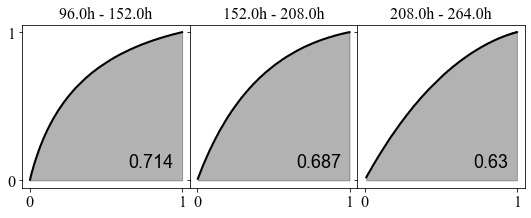

In [73]:
wd = 3

data_skip = 1#int((len(test_t2s)-1)/3)
print(data_skip)

good_indices = [0]

for kk in range(1,len(test_t2s)):
    this_index = good_indices[-1] + data_skip
    
    if this_index>len(test_t2s):
        break
    else:
        good_indices.append(this_index)
    
print(good_indices)

#l = int((len(test_t2s)-1)*wd)

l = int((len(good_indices)-1)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(good_indices)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

#for k in range(0,len(test_t2s)-1):
for ik in range(0,len(good_indices)-1):
    k = good_indices[ik]
    #print(test_t2s[k],test_t2s[k+1])
    
    #dx = copy.deepcopy(cdfs[test_t2s[k]][::-1])
    #dy = copy.deepcopy(cdfs[test_t2s[k+1]][::-1])
    
    all_aucs.append(auc(cdfs[test_t2s[k]][::-1],cdfs[test_t2s[k+1]][::-1]))
    
    #all_aucs.append(auc(dx_2,dy_2))
    
    label_text = str(round(all_aucs[-1],3))
    
    axs[ik].plot(cdfs[test_t2s[k]],cdfs[test_t2s[k+1]],lw=2,color='black',label=label_text)
    
    axs[ik].fill_between(cdfs[test_t2s[k]],0,cdfs[test_t2s[k+1]],color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    
    axs[ik].set_xticks((0,1))
    axs[ik].set_yticks((0,1))
    
    axs[ik].tick_params(axis='both',labelsize=16)
    
    axs[ik].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    
    #if k%2==0:
    #    axs[k].xaxis.tick_top()
    
        
        
    #axs[k].set_title('AUC = '+str(round(all_aucs[-1],3)),fontsize=16)
    
    axs[ik].set_title(str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h',fontsize=16)
        
#print(max(all_aucs))
#plt.tight_layout()
#plt.savefig('cytotoxicity-0h-AUC-48h_interval-full.png',dpi=300)  

try:
    wf = open('AUC-0h_summary.csv','a')
    wf.close()
except FileNotFoundError:
    wf = open('AUC-0h_summary.csv','w')
    wf.close()
    
print(str(abs(round(test_t2s[0]-test_t2s[1],0)))+','+str(round(max(all_aucs),2)),file=open('AUC-0h_summary.csv','a'))

In [ ]:
fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(len(test_t2s), hspace=0)

axs = gs.subplots(sharex=True)

for k in range(0,len(test_t2s)):
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    axs[k].plot(100-mean_cyto2,probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].tick_params(axis='y',labelsize=12)
    axs[k].set_xlim(48,102)
    
    
    axs[k].set_ylim(-0.005,1.2*np.max(probs[test_t2s[k]]))
    
    #plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
    
    axs[k].legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    if k==4:
        axs[k].set_ylabel(r'P[100-$C$ (%)]',size=24,rotation=90,labelpad=10)
    
plt.xticks(size=24) 
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(r'100-$C$ (%)',size=24,labelpad=10)
#plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
plt.xlim(100-np.max(mean_cyto),100-np.min(mean_cyto))

plt.tight_layout()

#plt.savefig('cyto-0h-T2-cuts.png',dpi=300)

In [ ]:
test_t2s = [100,150,200,250,300]
probs = {}

for k in test_t2s:
    probs[k] = np.zeros(shape=mean_cyto.shape)
    
for k in test_t2s:
    for i in range(0,mean_cyto.shape[0]):
        #probs[k][i] = st.norm.sf(k,loc=t2[i],scale=sigma[i])
        probs[k][i] = st.t.sf(k,df=dof,loc=mean_t2[i],scale=effective_sigma[i])
                
    #probs[k] *= 1.0/np.sum(probs[k])

In [ ]:
#fig, axs = plt.subplots(figsize=(8,7))
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

for k in test_t2s[:-1]:
    plt.plot(100-mean_cyto2,probs[k],lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    #plt.plot(probs[k],100-mean_cyto,lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    
    
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'Cytotoxicity, 100-$C$ (%)',size=22)
#plt.ylabel(r'P[100-$C$ (%)]',size=22)
plt.ylabel(r'P[T2$_{\mathrm{expected}} \geq$T2$_{\mathrm{cutoff}}$]',size=24,rotation=90,labelpad=10)
#plt.xlim(50,100)
plt.ylim(0,0.03)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='best')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

plt.savefig('cytotoxicity-T2-cutoff_prob-day0-48h.png',dpi=300)

In [ ]:
fitname = r'T2$_{\mathrm{est}}$ = (' + str(round(result.intercept,1)) + '$\pm$' + str(round(i_err,1)) + ')'
fitname += '+ (' + str(round(result.slope,1)) + '$\pm$' + str(round(s_err,1)) + ')$C$'

print(fitname)